# Oppgave 1 - Multippel Lineær Regresjon
---

__Problemstilling__: <i>Betaler vi ekstra for LEGO som assosieres med filmer eller spill?</i>

In [42]:
# Import av nødvendige biblioteker
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

## 0. Innlesning av datasettet
---

Datasettet ble lastet ned fra følgende <a href="https://www.tandfonline.com/doi/full/10.1080/26939169.2021.1946450?scroll=top&needAccess=true">artikkel</a>. (<i>Building a Multiple Linear Regression Model With LEGO Brick Data</i>) <br/>av Anna D. Peterson og Laura Ziegler.

In [43]:
df = pd.read_csv("lego.population.csv", sep = ",", encoding = "latin1")
df

,Item_Number,Set_Name,Theme,Pieces,Price,Amazon_Price,Year,Ages,Pages,Minifigures,Packaging,Weight,Unique_Pieces,Availability,Size
0,41916,Extra Dots - Series 2,DOTS,109.0,$3.99,$3.44,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
1,41908,Extra Dots - Series 1,DOTS,109.0,$3.99,$3.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
2,11006,Creative Blue Bricks,Classic,52.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,28.0,Retail,Small
3,11007,Creative Green Bricks,Classic,60.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,36.0,Retail,Small
4,41901,Funky Animals Bracelet,DOTS,33.0,$4.99,$4.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,10.0,Retail,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,45678,SPIKE Prime Set,LEGO® Education,528.0,$329.95,NaN,2020,Ages_10+,NaN,2.0,NaN,NaN,108.0,NaN,Small
1300,71367,Mario's House & Yoshi,LEGO® Super Mario,205.0,$29.99,NaN,2020,Ages_6+,NaN,2.0,Box,NaN,114.0,Retail,Small
1301,71368,Toad's Treasure Hunt,LEGO® Super Mario,464.0,$69.99,NaN,2020,Ages_8+,NaN,4.0,Box,NaN,195.0,Retail,Small
1302,71369,Bowser's Castle Boss Battle,LEGO® Super Mario,1010.0,$99.99,NaN,2020,Ages_8+,NaN,NaN,Box,NaN,346.0,Retail,Small


## 1. Rensing av datasettet
---
Før dataen kan analyseres velger vi å filtrere bort de kolonnene vi ikke ønsker å ta for oss. Vi fjerner deretter alle tupler i settet som inneholder mangler ( <code><i>NaN</i></code> eller <code><i>NULL</i></code> verdier ). For å kunne gjøre beregninger på <i>Price</i> kolonnen så gjøres verdiene om til flyttall. 

Koden har blitt hentet fra Jupyter-fil tilhørende oppgavebeskrivelsen.

In [44]:
# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Minifigures', 'Unique_Pieces', 'Availability']]

# fjerner observasjoner med manglende datapunkter
df2.dropna(inplace=True)

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)
df2

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Availability
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,1.0,52.0,Retail
16,Woody & RC,Disney,69.0,9.99,28.0,1.0,36.0,Retail
17,Mia's Summer Heart Box,Friends,85.0,7.99,36.0,1.0,41.0,Retail
18,Olivia's Summer Heart Box,Friends,93.0,7.99,40.0,2.0,48.0,Retail
19,Police Patrol Car,City,92.0,9.99,36.0,1.0,52.0,Retail - limited
...,...,...,...,...,...,...,...,...
1169,Ski Resort,City,806.0,89.99,328.0,11.0,348.0,Retail
1170,Disney Train and Station,Powered UP,2925.0,329.99,397.0,5.0,509.0,LEGO exclusive
1172,Tree House,Ideas,3036.0,199.99,428.0,4.0,482.0,Retail - limited
1173,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,13.0,692.0,LEGO exclusive


## 2. Preprosessering
---

Vi ønsker å finne ut hvorvidt prisen for LEGO produkter øker dersom settet er assosiert med en film eller et spill. For å kunne gjøre dette ønsker vi å lage en ny kolonne i datasettet som forteller hvorvidt legosettene er rettet mot et spill, en film eller ingen av delene. Dette blir en ny kategorisk variabel i datasettet.

For å finne hvilke legosett som går under hvilke kategori vil vi skrive ut hvilke temaer som finnes i datasettet.

In [45]:
print(df2['Theme'].value_counts())

Theme
City                 94
Friends              79
Star Wars            79
NINJAGO              76
Marvel               46
Disney               29
THE LEGO MOVIE 2     25
DUPLO                23
Harry Potter         22
Minecraft            21
Creator 3-in-1       20
Hidden Side          19
Jurassic World       18
Speed Champions      17
Batman               15
Juniors              11
Creator Expert       10
Ideas                 8
DC                    8
Trolls World Tour     8
Overwatch             7
LEGO Frozen 2         6
Unikitty              5
Classic               4
Minifigures           3
Spider-Man            2
Powerpuff Girls       2
Minions               2
Stranger Things       1
Monkie Kid            1
Powered UP            1
Name: count, dtype: int64


Vi ønsker å presisere at <i>THE LEGO MOVIE 2</i> ikke faller under <i>Movie</i> kategorien. Dette mener vi fordi The Lego Movie 2 er et konsept basert på LEGO. Det vi ser etter er legosett som er basert på filmer og spill, ikke omvendt.

Ovenfor ser vi hvilke temaer som finnes i datasettet. Etter gruppemedlemmenes egne kunnskaper, samt noen Google søk, kunne vi samle alle temaer knyttet til film i en liste, og spillene <i>Minecraft</i> og <i>Overwatch</i> i en annen liste. Disse listene kan da brukes med en funksjon til å tildele <i>Merchandise</i> attributtet for hver tuppel i datasettet.

In [46]:
# Alle tema-verdier med tilknytning til film eller serier.
movies = [
    'Star Wars',
    'Marvel',
    'Disney',
    'Harry Potter',
    'Jurassic World',
    'Batman',
    'DC',
    'Trolls World Tour',
    'LEGO Frozen 2',
    'Spider-Man',
    'Powerpuff Girls',
    'Minions',
    'Stranger Things'
]

# Alle tema-verdier med tilknytning til spill.
games = [
    'Minecraft',
    'Overwatch'
]

# Funksjon som bestemmer hvilke verdi Merchandise attributtet skal ha for en tuppel.
def categorize_merchandise(theme):
    if theme in movies:
        return 'Movie'
    elif theme in games:
        return 'Game'
    else:
        return 'Other'

# Påfører funksjonen på datasettet.
df2['Merchandise'] = df2['Theme'].apply(categorize_merchandise)
df2


,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Availability,Merchandise
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,1.0,52.0,Retail,Other
16,Woody & RC,Disney,69.0,9.99,28.0,1.0,36.0,Retail,Movie
17,Mia's Summer Heart Box,Friends,85.0,7.99,36.0,1.0,41.0,Retail,Other
18,Olivia's Summer Heart Box,Friends,93.0,7.99,40.0,2.0,48.0,Retail,Other
19,Police Patrol Car,City,92.0,9.99,36.0,1.0,52.0,Retail - limited,Other
...,...,...,...,...,...,...,...,...,...
1169,Ski Resort,City,806.0,89.99,328.0,11.0,348.0,Retail,Other
1170,Disney Train and Station,Powered UP,2925.0,329.99,397.0,5.0,509.0,LEGO exclusive,Other
1172,Tree House,Ideas,3036.0,199.99,428.0,4.0,482.0,Retail - limited,Other
1173,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,13.0,692.0,LEGO exclusive,Other


Den nye kolonnen er nå synlig i datasettet. Vi kan verifisere at implementasjonen virket etter hensikten ved å telle antall instanser av hver verdi for <i>Merchandise</i>. Vi vet at det finnes bare to temaer som knyttes til <i>Games</i> verdien: <i>Minecraft</i> som det finnes 21 legosett av, og <i>Overwatch</i> som det finnes 7 legosett av. Sammenlagt finnes det 28 legosett innenfor spill-kategorien, noe som bekreftes av koden nedenfor.

In [47]:
print(df2['Merchandise'].value_counts())

Merchandise
Other    396
Movie    238
Game      28
Name: count, dtype: int64


## 3. Utforskning av datasettet
---
Før vi starter med hypoteseutforming og regresjonsanalyser ønsker vi å danne en oversikt over dataen vi jobber med. Vi kan utforske datasettet ved å observere sammenhenger og egenskaper.

### Maksverdier og gjennomsnittlige verdier

I denne seksjonen ønsker vi å se mer på attributtene uten å ta dem i sammenheng med andre attributter.

Under får vi diverse informasjon om de numeriske attributtene i datasettet. Vi ser blant annet at prisen på legosettene varierer fra 3.99$ og opp til 699.99$, med en gjennomsnittlig verdi på 46.6$ og en varians på 54.1$. Vi ser også at gjennomsnittlig antall LEGO biter ligger på ca. 420 biter, samt at størst antall biter i ett sett ligger på 6020 biter.

In [48]:
df2.describe()

,Pieces,Price,Pages,Minifigures,Unique_Pieces
count,662.000000,662.000000,662.000000,662.000000,662.000000
mean,420.501511,46.627462,104.129909,3.285498,146.173716
std,565.788368,54.055037,86.221655,2.531807,112.829856
min,8.000000,3.990000,1.000000,1.000000,7.000000
25%,112.000000,19.990000,48.000000,2.000000,62.250000
50%,242.500000,29.990000,84.000000,3.000000,117.000000
75%,501.500000,59.990000,132.000000,4.000000,191.750000
max,6020.000000,699.990000,636.000000,28.000000,692.000000


Etter å ha observert dette kan det være interessant å se på hvilket legosett som er det dyreste. Vi ser at det er snakk om et legosett av den ikoniske <i>Imperial Star Destroyer</i> fra <i>Star Wars</i> universet. Noe som man burde merke seg er at selv om dette er det dyreste legosettet, så er det ikke legosettet med flest legobiter, trass i den høyeste korrelasjonen mellom pris og antall legobiter. 

In [49]:
print(df2.loc[df2['Price'].idxmax()])

Set_Name         Imperial Star Destroyer
Theme                          Star Wars
Pieces                            4784.0
Price                             699.99
Pages                              444.0
Minifigures                          2.0
Unique_Pieces                      445.0
Availability              LEGO exclusive
Merchandise                        Movie
Name: 825, dtype: object


Vi vil derfor finne ut hvilke legosett det er som har flest antall biter. Vi ser at det er snakk om det hjertevarmende <i>Hogwarts Castle</i> fra <i>Harry Potter</i>. Det observeres at til tross for å inneholde over 1200 flere LEGO biter enn <i>Imperial Star Destroyer</i> settet, så er det likevel hele 300$ billigere.

In [50]:
print(df2.loc[df2['Pieces'].idxmax()])

Set_Name         Hogwarts Castle
Theme               Harry Potter
Pieces                    6020.0
Price                     399.99
Pages                      636.0
Minifigures                 28.0
Unique_Pieces              624.0
Availability      LEGO exclusive
Merchandise                Movie
Name: 821, dtype: object


Videre ønsker vi å se på gjennomsnittlig antall LEGO biter innenfor kategoriene <i>Movie</i>, <i>Game</i> og <i>Other</i>. Vi ser at <i>Movie</i> kategorien kommer på topp med 437 biter i gjennomsnitt per legosett, og at <i>Game</i> kategorien har det laveste gjennomsnittet på 357.5 biter.

In [51]:
df2.groupby('Merchandise')['Pieces'].mean().sort_values(ascending=False)[:3]

Merchandise
Movie    437.100840
Other    414.979798
Game     357.500000
Name: Pieces, dtype: float64

Ved å se på gjennomsnittlig pris for kategoriene får vi lignende rangering med <i>Movie</i> øverst med en gjennomsnittspris på 50.9$, og <i>Game</i> nederst med beskjedne 36.6$ som gjennnomsnittspris.

In [52]:
df2.groupby('Merchandise')['Price'].mean().sort_values(ascending=False)[:3]

Merchandise
Movie    50.905966
Other    44.765253
Game     36.597143
Name: Price, dtype: float64

For å få et bedre inntrykk av prisfordelingen på legosettene kan vi plotte et histogram som viser antall forekomster av legosett i forskjellige prisklasser. Vi kan se at de mest frekvente prisene også er de laveste. En liten forhøyning rett før x=700 viser til legosettet <i>Imperial Star Destroyer</i>.

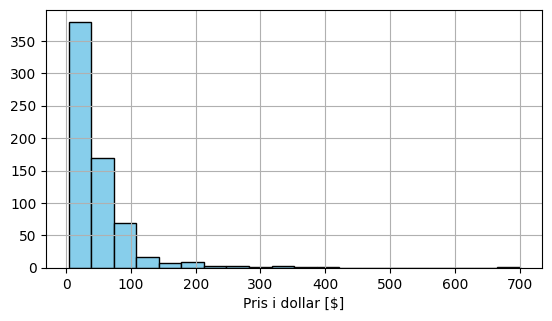

In [53]:
plt.hist(df2['Price'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Pris i dollar [$]')
plt.ylabel('')
plt.gca().set_aspect(1)
plt.grid()
plt.show()

Nedenfor ser vi et boksplott av prisene vi finner på de forskjellige legosettene i datasettet. Vi ser at det finnes flere statistiske uteliggere i datasettet som er markert som punkter. Vi velger å ikke fjerne disse da vi anser dem som relevante for problemstillingen, og fordi at vi vet at det ikke er feil på datasettet, da prisene på de dyrere legosettene enkelt kan verifiseres. Vi ser også at selve boksen er smal, noe som vitner om at de fleste tuplene i datasettet har priser som faller mellom ca 50$ og 75$. Dette stemmer overens med tabellen vi fikk ovenfor der vi så at gjennomsnittlig pris på et legosett lå på rundt 46.6$. 

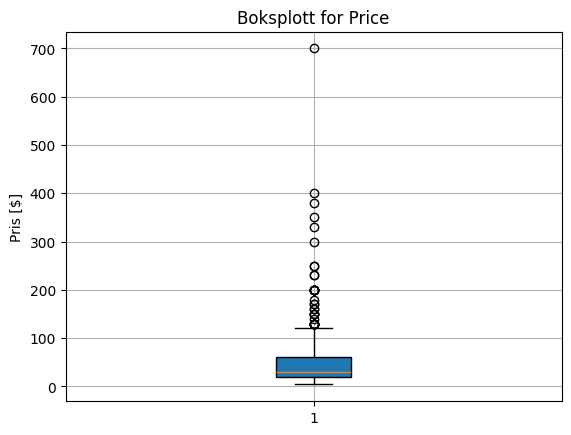

In [54]:
plt.boxplot(df2['Price'], patch_artist=True)
plt.ylabel('Pris [$]')
plt.title('Boksplott for Price')
plt.grid()
plt.show()

### Korrelasjon

For å finne ut hvordan attributtene påvirker hverandre lager vi en korrelasjonsmatrise of plotter det som et "heatmap". Matrisen viser oss at prisen har stor korrelasjonskoeffesient med alle attributtene vi regner for. Vi kan se at Pris og antall biter i Legosettet har høyest korrelasjon, med en koeffesient på hele 0.92. Den laveste (men fremdeles ganske høye) korrelasjonen finnes mellom pris og antall minifigurer i legosettet, som ligger på 0.58.

Vi kan også observere at det finnes ingen negative korrelasjoner, hvilket betyr at forhøyede verdier i attributtene 'Pieces', 'Pages', 'Minifigures' og 'Unique_Pieces' vil medføre en økning i prisen på legosettet også. Matrisen har vist oss at disse attributtene har mye å si på legosettets butikkpris. Hvorvidt problemstillingen kan bekreftes eller avkreftes gjenstår fremdeles å se.

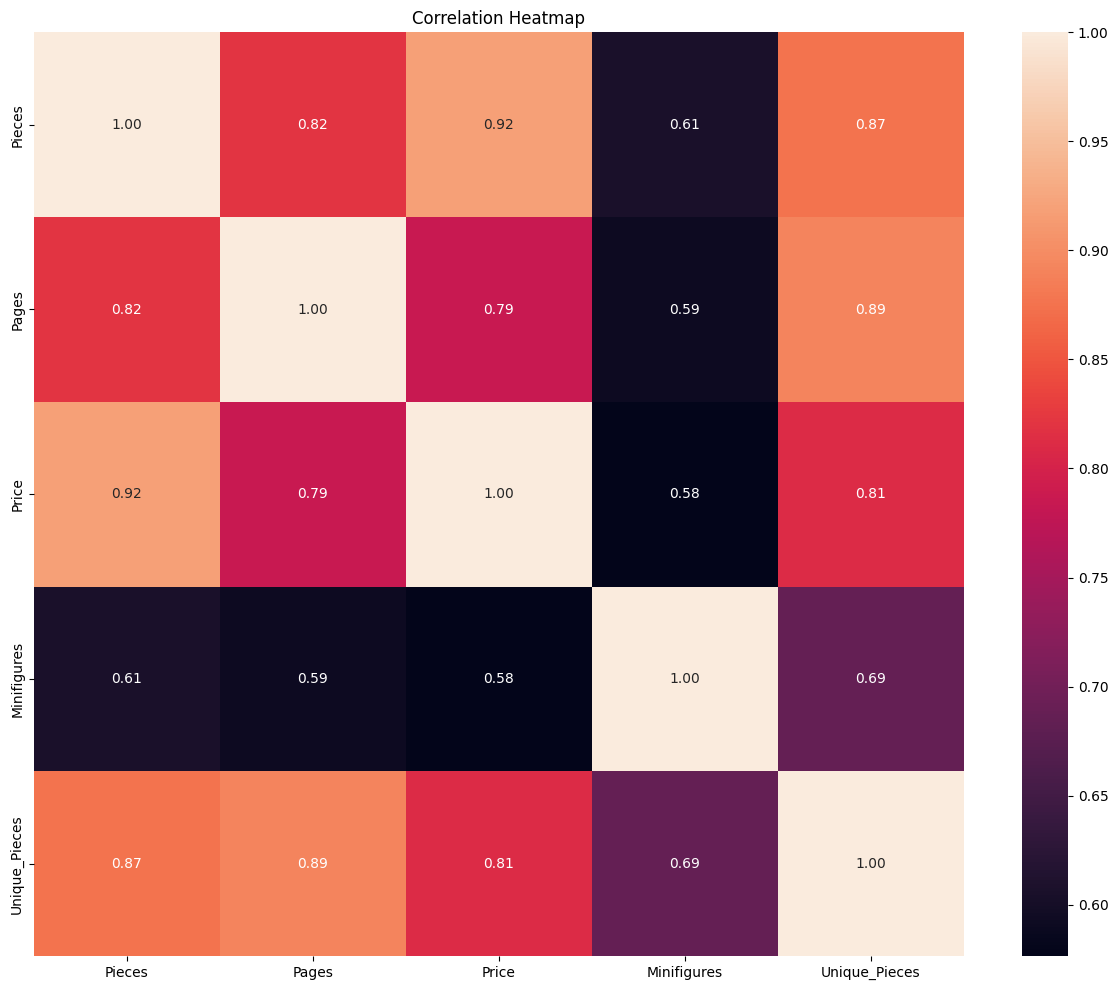

In [55]:
dfc = df2[[ 'Pieces', 'Pages', 'Price', 'Minifigures', 'Unique_Pieces' ]]

correlation_matrix = dfc.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Under vises et spredningsplot over legosett med dimensjonene <i>Pieces</i> og <i>Price</i>. Som forventet ser vi at det er størst samling ved lave verdier for begge dimensjonene. Her er det også lite varasjon mellom punktene.

Man kan også merke seg at når antall legobiter og pris øker til det maksimale i datasettet, så ser vi større variasjon. Punktet med høyest y-verdi antas å være <i>Imperial Star Destroyer</i>, og punktet med høyest x-verdi antas å være <i>Hogwarts Castle</i>.

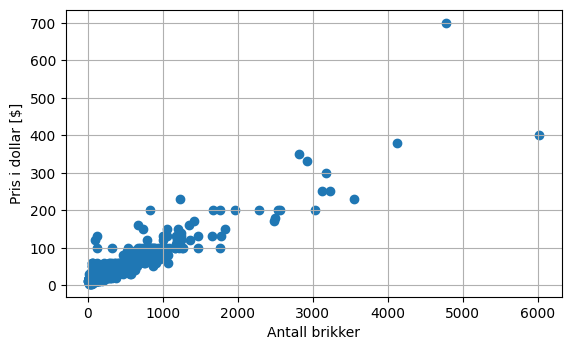

In [56]:
plt.scatter(df2['Pieces'], df2['Price'])
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.gca().set_aspect(5)
plt.grid()
plt.show()

Nedenfor vises parplot for attributtene <i>Price</i>, <i>Pieces</i>, <i>Pages</i>, <i>Minifigures</i> og <i>Unique_Pieces</i> ordnet etter kategoriene innenfor <i>Merchandise</i>. Man kan merke seg at i parplottene hvor <i>Price</i> er på y-aksen, så er <i>Movie</i> legosett mer dominant i de øvre y-verdiene. Som i spredningsplottet ovenfor kan vi også se at det er større samnling med punkter ved lave x- og y-verdier. 

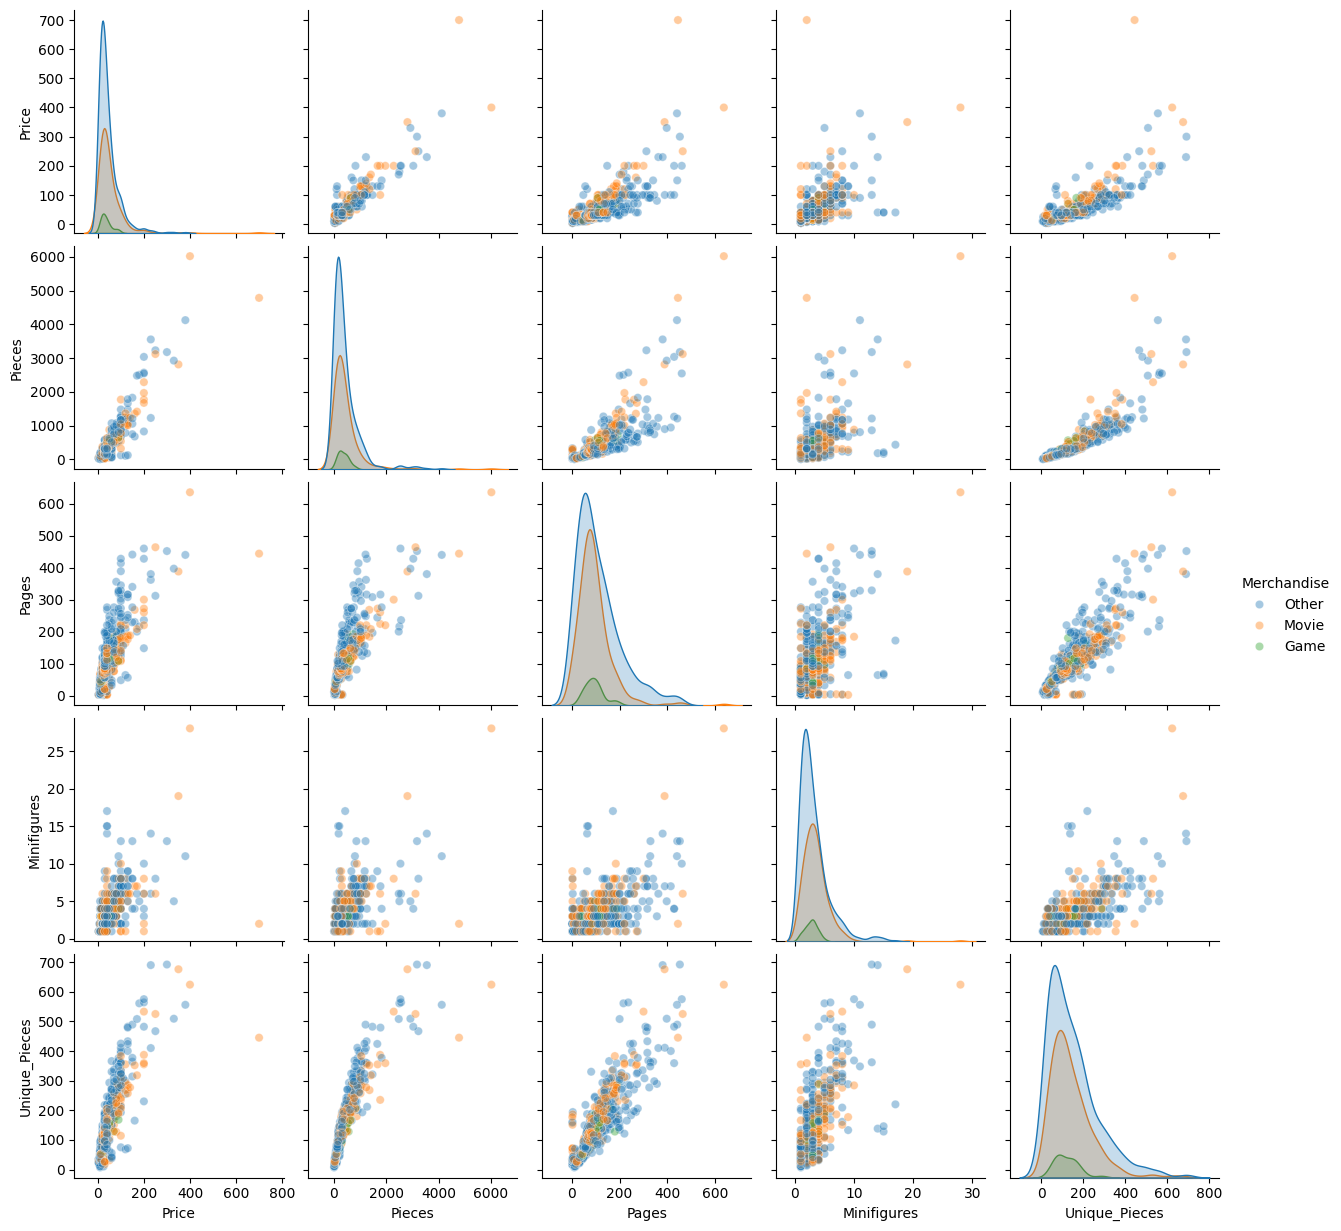

In [57]:
sns.pairplot(df2, vars = ['Price', 'Pieces', 'Pages', 'Minifigures', 'Unique_Pieces'],
             hue = 'Merchandise', 
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

## 4. Hypotese
---

Før vi starter med regresjonsanalysen ønsker vi å danne en hypotese til problemstillingen våres. Etter å ha utforsket datasettet i Punkt 2, har vi gjort visse observasjoner vi ønsker å trekke fram:

* Det dyreste legosettet er basert på film
* Legosettet med flest legobiter er basert på film
* Når prisen er lav og antall biter er mindre er det mindre forskjell på hvorvidt legosettene er fra film og spill eller ikke
* Legosett med mange legobiter har en tendens til å være basert på film
* Det er en veldig sterk korrelasjon mellom pris og antall biter i legosettene

Ut i fra disse observasjonene danner vi derfor følgende hypotese:

<i>Legosett inspirert fra film og spill koster mer enn andre legosett, og denne variasjonen øker når antall legobiter gjør det.</i>

Ut i fra det vi allerede kan se fra datasettet så har vi ikke mange store og dyre legosett som ikke er basert på film eller spill. Dette kan gjøre regresjonen noe mindre presis. For å få mer nøyaktige beregninger burde vi derfor hatt flere instanser av ikke-film-eller-spill-inspirerte legosett med mange legobiter.

## 5. Regresjonsanalyse
---
I denne seksjonen skal vi bruke multippel lineær regresjon for å prøve å bekrefte eller avvise hypotesen våres. Vi starter med å lage en lineær regresjon uten å ta hensyn til <i>Merchandise</i> attributtet. Vi har valgt å bruke <i>Price</i> som responsvariabel, og <i>Pieces</i> som forklaringsvariabel.

In [58]:
modell = smf.ols('Price ~ Pieces', data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     3545.
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          1.41e-267
Time:                        05:04:03   Log-Likelihood:                -2967.3
No. Observations:                 662   AIC:                             5939.
Df Residuals:                     660   BIC:                             5948.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7406      1.038      9.383      0.000       7.702      11.779
Pieces         0.0877      0.001     59.537      0.000       0.085       0.091
==============================================================================
Omnibus:                      621.361   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59679.642
Skew:                           3.777   Prob(JB):                         0.00
Kurtosis:                      48.897   Cond. No.                         878.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

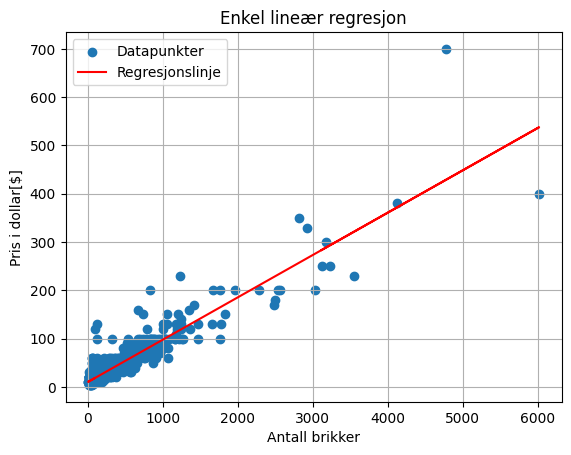

In [59]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Pieces'])
regression_y = slope * regression_x + intercept

plt.scatter(df2['Pieces'], df2['Price'], label='Datapunkter')
plt.plot(regression_x, regression_y, color='red', label='Regresjonslinje')
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar[$]')
plt.title('Enkel lineær regresjon')
plt.legend()
plt.grid()
plt.show()

### Residualplott og Kvantilplott

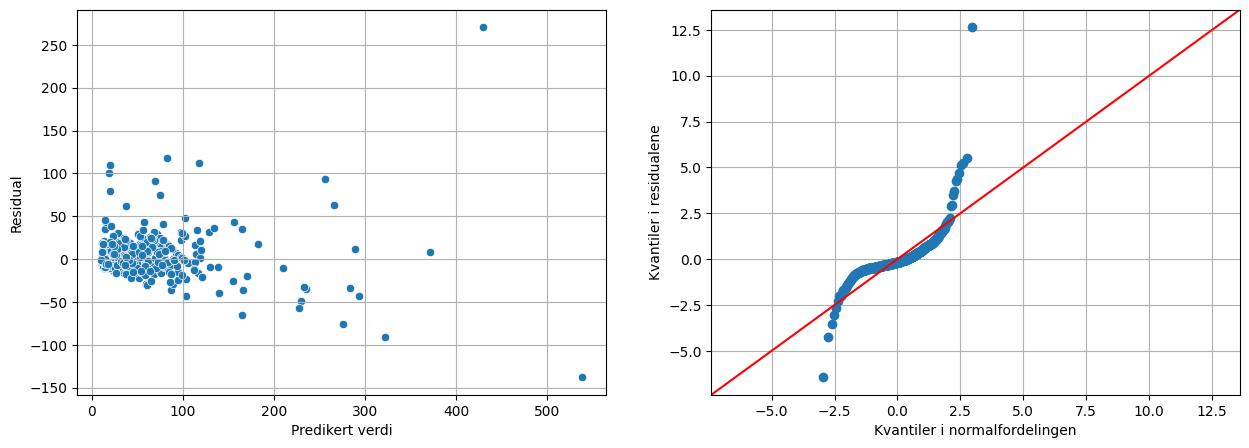

In [60]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = resultat.fittedvalues, y = resultat.resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")
axis[0].grid()

sm.qqplot(resultat.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.grid()
plt.show()

In [61]:
resultater = []
categories = ['Movie', 'Game', 'Other']
subset_df = df2[df2['Merchandise'].isin(categories)]

for i, merch in enumerate(categories):
    modell3 = smf.ols('Price ~ Pieces' , data = subset_df[subset_df['Merchandise'].isin([merch])])
    resultater.append(modell3.fit())

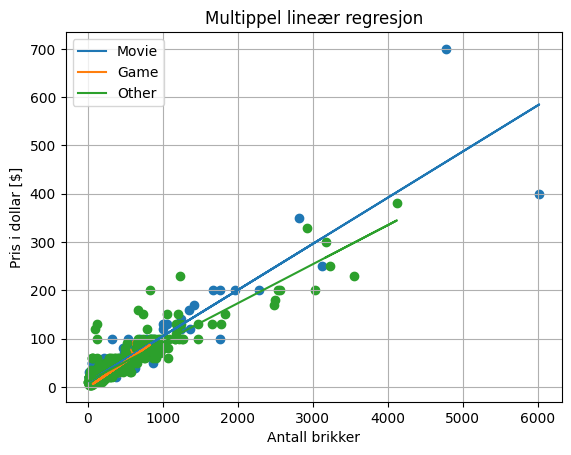

In [62]:
for i, merch in enumerate(categories):
    slope = resultater[i].params['Pieces']
    intercept = resultater[i].params['Intercept']

    regression_x = np.array(subset_df[subset_df['Merchandise'].isin([merch])]['Pieces'])
    regression_y = slope * regression_x + intercept

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['Merchandise'].isin([merch])]['Pieces'], subset_df[subset_df['Merchandise'].isin([merch])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=merch)
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.title('Multippel lineær regresjon')
plt.legend()
plt.grid()
plt.show()

### Regresjon med binær klassifisering av <i>Merchandise</i> attributtet

In [63]:
df3 = df2.copy()
value_mapping = {
    'Other': -1, 
    'Movie': 1, 
    'Game': 1
}
df3['Merchandise'] = df3['Merchandise'].replace(value_mapping)
print(df3['Merchandise'].value_counts())

Merchandise
-1    396
 1    266
Name: count, dtype: int64


In [64]:
Y = df3['Price']
X = df3[['Merchandise', 'Pieces', 'Minifigures', 'Unique_Pieces']] 
X = sm.add_constant(X) 

model = sm.OLS(Y, X).fit()

model_summary = model.summary()
print(model_summary)

coefficients = model.params
p_values = model.pvalues
r_squared = model.rsquared

print("\Koeffesienter:\n", coefficients)
print("\nP-verdier:\n", p_values)
print("\nR-kvadrert verdier:\n", r_squared)

movie_game_coefficient = coefficients['Merchandise']
movie_game_p_value = p_values['Merchandise']

print("\nKoeffesienten for Movie-Game-Assosiasjon:", movie_game_coefficient)
print("Er koeffesienten statistisk signifikant? ", "Yes" if movie_game_p_value < 0.05 else "No")

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     893.4
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          5.49e-264
Time:                        05:04:04   Log-Likelihood:                -2963.8
No. Observations:                 662   AIC:                             5938.
Df Residuals:                     657   BIC:                             5960.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.0910      1.592      5.081

### Regresjon for den kategoriske verdien <i>Other</i>

In [65]:
subset_df2 = df2[df2['Merchandise'].isin(['Other'])]

formel = 'Price ~ Pieces'

modell = smf.ols(formel, data = subset_df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1995.
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          2.72e-156
Time:                        05:04:04   Log-Likelihood:                -1736.7
No. Observations:                 396   AIC:                             3477.
Df Residuals:                     394   BIC:                             3485.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1984      1.234      9.075      0.000       8.772      13.624
Pieces         0.0809      0.002     44.669      0.000       0.077       0.084
==============================================================================
Omnibus:                      277.986   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3721.993
Skew:                           2.854   Prob(JB):                         0.00
Kurtosis:                      16.893   Cond. No.                         859.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

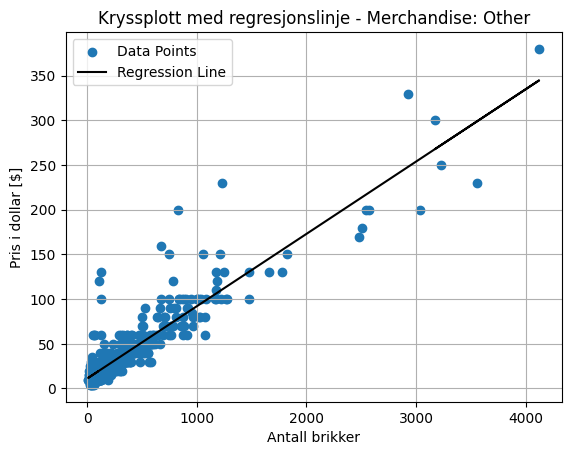

In [66]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(subset_df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(subset_df2['Pieces'], subset_df2['Price'], label = 'Data Points')
plt.plot(regression_x, regression_y, color = 'black', label = 'Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.title('Kryssplott med regresjonslinje - Merchandise: Other')
plt.legend()
plt.grid()
plt.show()

### Regresjon for den kategoriske verdien <i>Movie</i>

In [67]:
subset_df2 = df2[df2['Merchandise'].isin(['Movie'])]

formel = 'Price ~ Pieces'

modell = smf.ols(formel, data = subset_df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1491.
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          5.43e-104
Time:                        05:04:04   Log-Likelihood:                -1093.9
No. Observations:                 238   AIC:                             2192.
Df Residuals:                     236   BIC:                             2199.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1063      1.900      4.793      0.000       5.364      12.849
Pieces         0.0956      0.002     38.620      0.000       0.091       0.101
==============================================================================
Omnibus:                      180.882   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25783.769
Skew:                           1.982   Prob(JB):                         0.00
Kurtosis:                      53.836   Cond. No.                         934.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

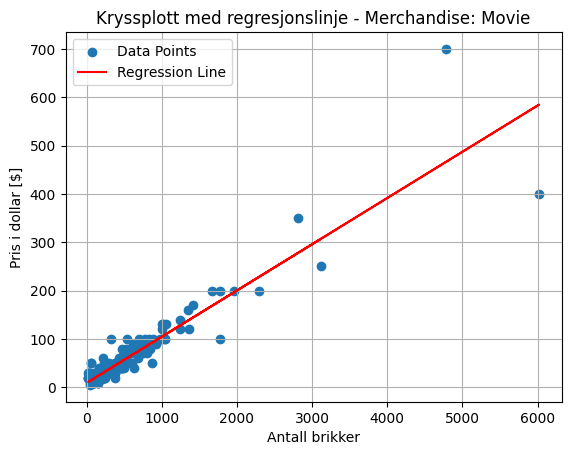

In [68]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(subset_df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(subset_df2['Pieces'], subset_df2['Price'], label = 'Data Points')
plt.plot(regression_x, regression_y, color = 'red', label = 'Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.title('Kryssplott med regresjonslinje - Merchandise: Movie')
plt.legend()
plt.grid()
plt.show()

### Regresjon for den kategoriske verdien <i>Game</i>

In [69]:
subset_df2 = df2[df2['Merchandise'].isin(['Game'])]

formel = 'Price ~ Pieces'

modell = smf.ols(formel, data = subset_df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     171.3
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           5.97e-13
Time:                        05:04:04   Log-Likelihood:                -98.512
No. Observations:                  28   AIC:                             201.0
Df Residuals:                      26   BIC:                             203.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4227      3.316     -0.429      0.671      -8.240       5.394
Pieces         0.1063      0.008     13.089      0.000       0.090       0.123
==============================================================================
Omnibus:                        4.466   Durbin-Watson:                   2.471
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                2.984
Skew:                           0.768   Prob(JB):                        0.225
Kurtosis:                       3.445   Cond. No.                         846.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

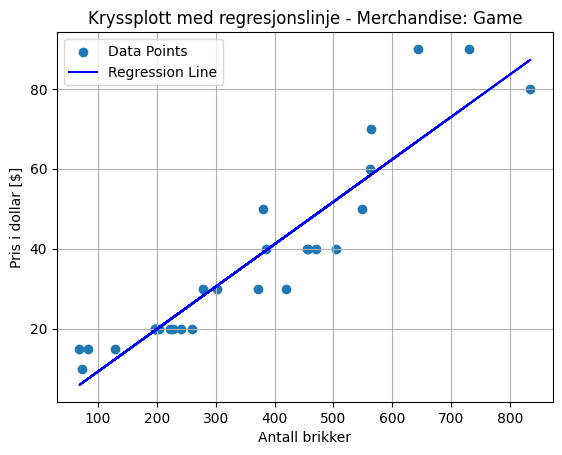

In [70]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(subset_df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(subset_df2['Pieces'], subset_df2['Price'], label = 'Data Points')
plt.plot(regression_x, regression_y, color = 'Blue', label = 'Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.title('Kryssplott med regresjonslinje - Merchandise: Game')
plt.legend()
plt.grid()
plt.show()

### Utskrift av stigningstall og konstantledd for de lineære regresjonnene

In [71]:
regression_models = {}
unique_types = df2['Merchandise'].unique()

for type_value in unique_types:

    df_subset = df2[df2['Merchandise'] == type_value]

    X = df_subset[['Pieces']]
    y = df_subset['Price']

    model = LinearRegression()
    model.fit(X, y)

    regression_models[type_value] = model

for type_value, model in regression_models.items():
    print(f"Regresjon for {type_value}:")
    print("-"*50)
    print(f"Stigningstall (Slope): {model.coef_[0]}")
    print(f"Konstantledd (Intercept): {model.intercept_}")
    print("\n")

Regresjon for Other:
--------------------------------------------------
Stigningstall (Slope): 0.08088789724213474
Konstantledd (Intercept): 11.198409268700793


Regresjon for Movie:
--------------------------------------------------
Stigningstall (Slope): 0.09562925874811863
Konstantledd (Intercept): 9.106337027030328


Regresjon for Game:
--------------------------------------------------
Stigningstall (Slope): 0.10634934368393002
Konstantledd (Intercept): -1.422747509862127




### Plotting av funksjonene som like lange linjer og uten datapunkter

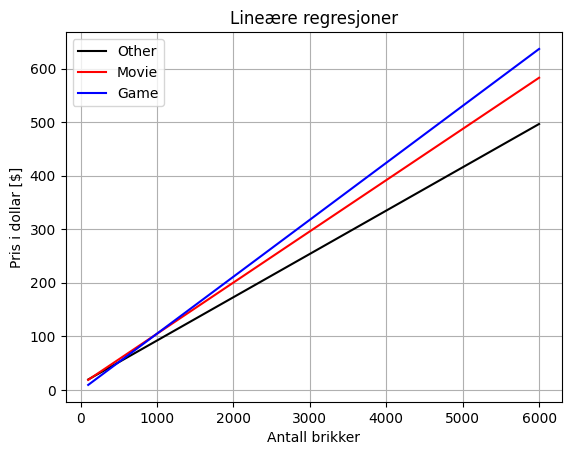

In [72]:
def reg_(model, x):
    return model.coef_[0] * x + model.intercept_

x1 = np.linspace(100, 6000, 10000)

plt.plot(x1, reg_(regression_models['Other'], x1), color='black', label='Other')
plt.plot(x1, reg_(regression_models['Movie'], x1), color='Red', label='Movie')
plt.plot(x1, reg_(regression_models['Game'], x1), color='Blue', label='Game')
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.title('Lineære regresjoner')
plt.legend()
plt.grid()
plt.show()

### Plotting av regresjonene med datapunktene

In [73]:
formel = 'Price ~ Pieces * Merchandise'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     747.9
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          3.90e-268
Time:                        05:04:04   Log-Likelihood:                -2950.6
No. Observations:                 662   AIC:                             5913.
Df Residuals:                     656   BIC:                             5940.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.4227      8.209     -0.173      0.862     -17.542      14.696
Merchandise[T.Movie]           10.5291      8.374      1.257      0.209      -5.914      26.972
Merchandise[T.Other]           12.6212      8.316      1.518      0.130      -3.707      28.950
Pieces                          0.1063      0.020      5.288      0.000       0.067       0.146
Pieces:Merchandise[T.Movie]    -0.0107      0.020     -0.530      0.596      -0.050       0.029
Pieces:Merchandise[T.Other]    -0.0255      0.020     -1.260      0.208      -0.065       0.014
==============================================================================
Omnibus:                      479.856   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41296.905
Skew:                           2.462   Prob(JB):                         0.00
Kurtosis:                      41.379   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

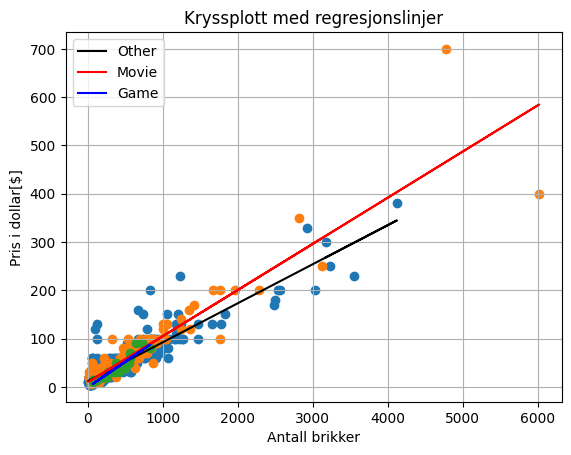

In [74]:
intercept = [resultat.params['Merchandise[T.Other]'], resultat.params['Merchandise[T.Movie]'], 0] + resultat.params['Intercept']
slope = [resultat.params['Pieces:Merchandise[T.Other]'], resultat.params['Pieces:Merchandise[T.Movie]'], 0] + resultat.params['Pieces']

merchandises = ['Other', 'Movie', 'Game']
colors = ['Black', 'Red', 'Blue']

for i, merch in enumerate(merchandises):
    
    regression_x = np.array(df2[df2['Merchandise'].isin([merch])]['Pieces'])
    regression_y = slope[i] * regression_x + intercept[i]
    
    plt.scatter(df2[df2['Merchandise'].isin([merch])]['Pieces'], df2[df2['Merchandise'].isin([merch])]['Price'])
    plt.plot(regression_x, regression_y, label = merch, color = colors[i])

plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar[$]')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

### Residualplott og QQ-plott

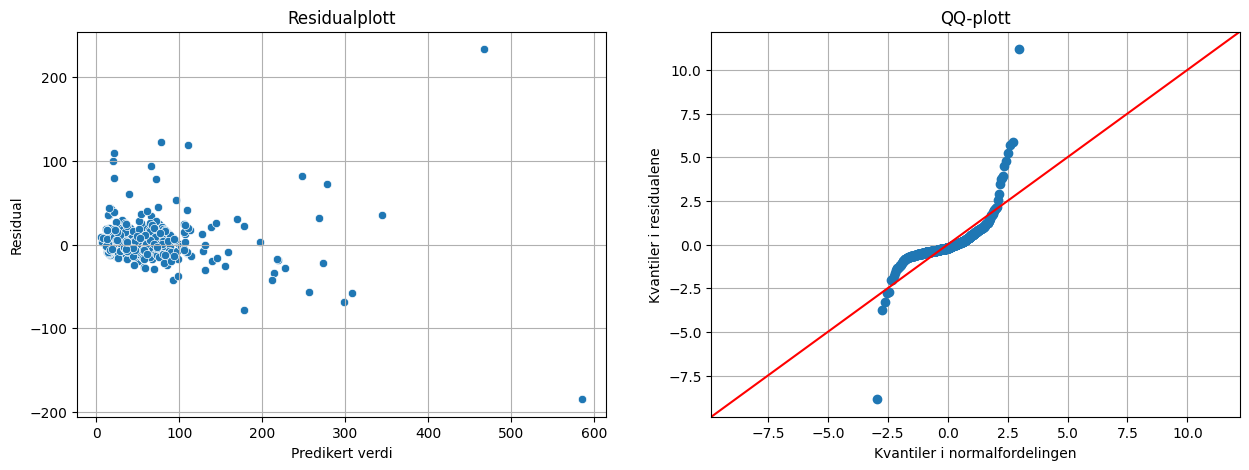

In [75]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = resultat.fittedvalues, y = resultat.resid, ax = axis[0])
axis[0].set_xlabel('Predikert verdi')
axis[0].set_ylabel('Residual')
axis[0].set_title('Residualplott')
axis[0].grid()

sm.qqplot(resultat.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_xlabel('Kvantiler i normalfordelingen')
axis[1].set_ylabel('Kvantiler i residualene')
axis[1].set_title('QQ-plott')
axis[1].grid()

plt.show()